# Deeper U-net

## Description

**Kaggle mean Intersection over Union** : 0.44

**Local test mean Intersection over Union**: 0.46

**Description**: Modification of the baseline U-net with more layers and Weighted Dice as loss function

**Motivation**: Try to improve the performance


## Google Drive - Connecting to the project

In [1]:
from google.colab import drive
import sys
drive.mount('/content/drive')
project_path = "/content/drive/MyDrive/Colab Notebooks/ANN/le acque del friuli - Homework 2"
%cd {project_path}
sys.path.append(project_path)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1CRSDpvo8yN6Wc7UchdjWSs6h8RroV7e4/le acque del friuli - Homework 2


## Imports

In [2]:
%load_ext autoreload
%autoreload 2

# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

from datetime import datetime
from tensorflow.keras.metrics import MeanIoU

## Parameters

In [3]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 10

# Set maximum number of training epochs
EPOCHS = 1000

# Number of classes
NUM_CLASSES = 5

## Load Data

In [4]:
# Load the dataset
data = np.load("dataset/cleaned_dataset.npz")
test_img = data['test_set']

# Split the dataset in images and labels array
X = data['images']
y = data['labels']
y = tfk.utils.to_categorical(y, num_classes=NUM_CLASSES)

# Split the dataset into training, test, and validation
train_img, test_img_local, train_lbl, test_lbl_local = train_test_split(X, y, test_size=0.2, random_state=seed)
train_img, val_img, train_lbl, val_lbl = train_test_split(train_img, train_lbl, test_size=0.2, random_state=seed)

In [5]:
# Function to create a dataset with batch and shuffle
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Shuffle the dataset if requested
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [6]:
# Create the training dataset
train_dataset = make_dataset(train_img, train_lbl, batch_size=BATCH_SIZE, shuffle=True, augment=True, seed=seed)

# Create the validation dataset
val_dataset = make_dataset(val_img, val_lbl, batch_size=BATCH_SIZE, shuffle=False, augment=False, seed=seed)

## Model Implementation

In [7]:
# Definition of a U-net block
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    return x

In [8]:
# Definition of the model
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 256, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_3])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    u3 = tfkl.Concatenate()([u3, down_block_1])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [9]:
# Model contruction
model = get_unet_model()

# Print a detailed summary of the model
model.summary(expand_nested=False, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 1,952,069 (7.45 MB)

 Trainable params: 1,949,253 (7.44 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Training

In [10]:
# Model compilation with Adam as optimizer and Dice as loss function
model.compile(
    loss=tfk.losses.Dice(),
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    metrics=["accuracy",tfk.metrics.OneHotMeanIoU(NUM_CLASSES,ignore_class=0)]
)

In [11]:
# Implementation of early stopping as a technique to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

In [12]:
# Actual training of the model with the given parameters
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1,
).history

Epoch 1/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.4245 - loss: 0.6309 - one_hot_mean_io_u: 0.1910 - val_accuracy: 0.2501 - val_loss: 0.7609 - val_one_hot_mean_io_u: 0.0283
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.6107 - loss: 0.4189 - one_hot_mean_io_u: 0.3147 - val_accuracy: 0.3284 - val_loss: 0.6902 - val_one_hot_mean_io_u: 0.1313
Epoch 3/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.6070 - loss: 0.4090 - one_hot_mean_io_u: 0.3015 - val_accuracy: 0.4854 - val_loss: 0.5357 - val_one_hot_mean_io_u: 0.2302
Epoch 4/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 0.6311 - loss: 0.3794 - one_hot_mean_io_u: 0.3284 - val_accuracy: 0.4696 - val_loss: 0.5392 - val_one_hot_mean_io_u: 0.2340
Epoch 5/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.6570 - loss: 0.3504 - one_hot_mean_io_u: 0.3498 - val_accuracy: 0.5023 - val_loss: 0.5056 - val_one_hot_mean_io_u: 0.2069
Epoch 6/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/ste

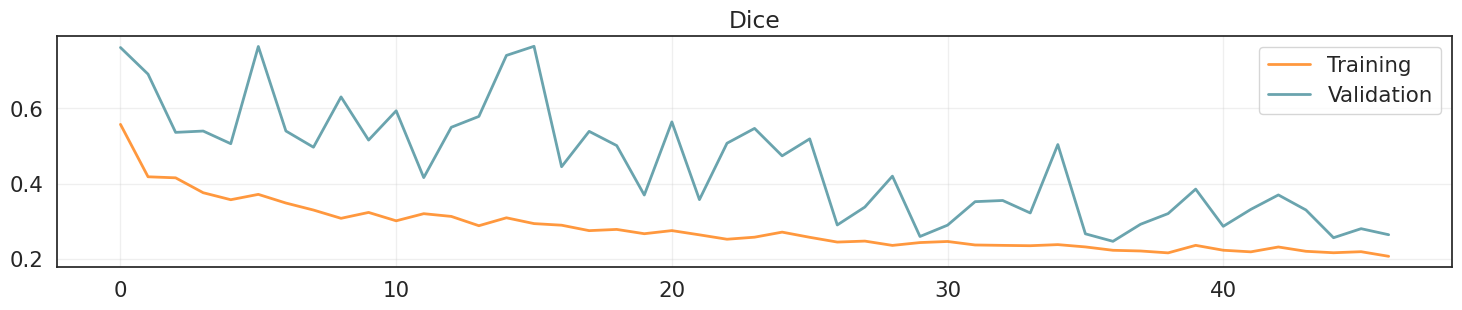

In [13]:
# Plot the loss function value over epochs
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Dice')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Test Prediction and Final Evaluation

In [17]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(test_img_local, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)
test_lbl_local = np.argmax(test_lbl_local, axis=-1)

In [24]:
# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_lbl_local.flatten(), test_predictions.flatten())
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted', zero_division=0)
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_lbl_local.flatten(), test_predictions.flatten(), average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Calculate and display test set mean Intersection Over Union score
# one_hot_pred = tfk.utils.to_categorical(test_predictions, num_classes=NUM_CLASSES)
test_miou = MeanIoU(NUM_CLASSES)
test_miou.update_state(test_lbl_local, test_predictions)
test_miou = test_miou.result().numpy()
print(f'Mean Intersection over Union over the test set: {round(test_miou, 4)}')

Accuracy score over the test set: 0.7352
Precision score over the test set: 0.7335
Recall score over the test set: 0.7352
F1 score over the test set: 0.728
Mean Intersection over Union over the test set: 0.459199994802475


## Save

In [25]:
# Save the model
from datetime import datetime
current_time = datetime.now().strftime("%d|%m-%H:%M")
model_filename = f'UNet_{current_time}.keras'
print("Saved as :",model_filename)
model.save(f'models/{model_filename}', include_optimizer=False)

Saved as : UNet_14|12-11:47.keras


## Submission

In [26]:
# Predict the masks for the submission
preds = model.predict(test_img)
preds = np.argmax(preds, axis=-1)

314/314 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step


In [27]:
# Converts segmentation predictions into a DataFrame format for Kaggle
def y_to_df(y) -> pd.DataFrame:
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [28]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submissions/submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)